In [ ]:
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
import re
import matplotlib.pyplot as plt
import itertools
import sklearn.datasets
from sklearn.metrics.pairwise import euclidean_distances
import math
import random
import Graph_Sampling as gs

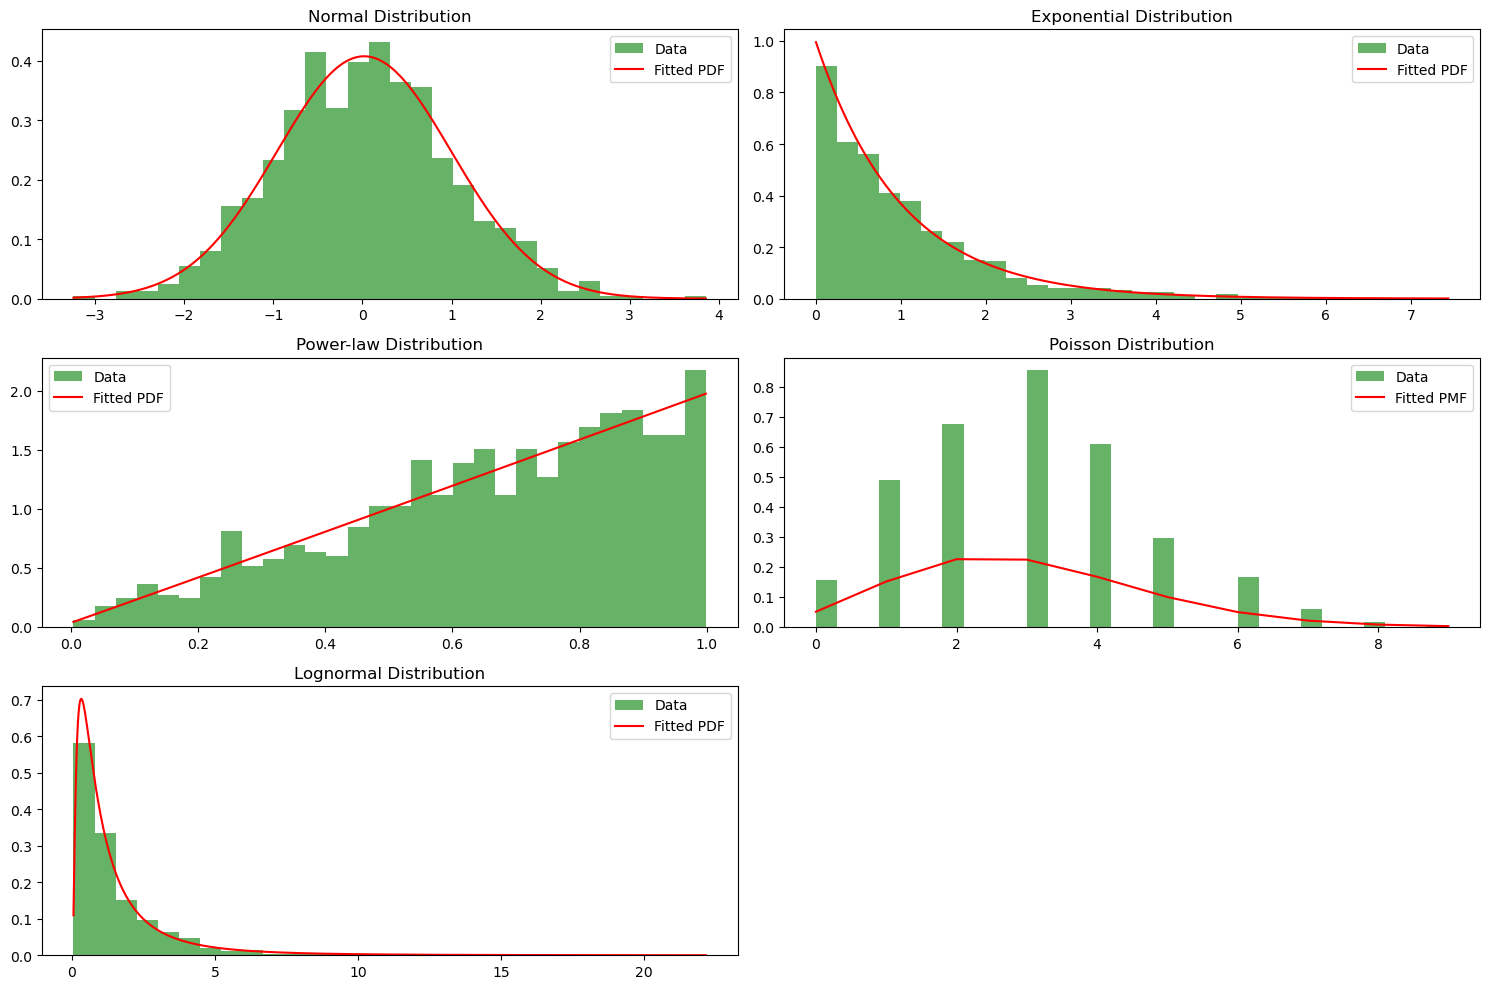

KS-test results:
Normal: KS Statistic = 0.0215, p-value = 0.7370
Exponential: KS Statistic = 0.0203, p-value = 0.7965
Power-law: KS Statistic = 0.0180, p-value = 0.8953
Poisson: KS Statistic = 0.2543, p-value = 0.0000
Lognormal: KS Statistic = 0.0162, p-value = 0.9526


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, powerlaw, poisson, lognorm, kstest

# Generate data
np.random.seed(42)  # For reproducibility
n_samples = 1000

# 1. Normal distribution
data_normal = np.random.normal(loc=0, scale=1, size=n_samples)
params_normal = norm.fit(data_normal)

# 2. Exponential distribution
data_expon = np.random.exponential(scale=1, size=n_samples)
params_expon = expon.fit(data_expon)

# 3. Power-law distribution
data_power = np.random.power(a=2, size=n_samples)
params_power = powerlaw.fit(data_power)

# 4. Poisson distribution
data_poisson = np.random.poisson(lam=3, size=n_samples)
# Fitting Poisson is done differently, as scipy.stats.poisson.fit isn't available.
lambda_poisson = np.mean(data_poisson)  # MLE for Poisson

# 5. Lognormal distribution
data_lognormal = np.random.lognormal(mean=0, sigma=1, size=n_samples)
params_lognormal = lognorm.fit(data_lognormal)

# Visualization and KS-tests
distributions = [
    ("Normal", data_normal, norm, params_normal),
    ("Exponential", data_expon, expon, params_expon),
    ("Power-law", data_power, powerlaw, params_power),
    ("Poisson", data_poisson, poisson, (lambda_poisson,)),
    ("Lognormal", data_lognormal, lognorm, params_lognormal)
]

results = {}

plt.figure(figsize=(15, 10))
for i, (name, data, dist, params) in enumerate(distributions, 1):
    # Histogram
    plt.subplot(3, 2, i)
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

    # Fitted density
    x = np.linspace(min(data), max(data), 1000)
    if name == "Poisson":
        pmf_values = dist.pmf(np.round(x), *params)
        plt.plot(np.round(x), pmf_values, 'r-', label='Fitted PMF')
    else:
        pdf_values = dist.pdf(x, *params)
        plt.plot(x, pdf_values, 'r-', label='Fitted PDF')

    plt.title(f"{name} Distribution")
    plt.legend()

    # KS test
    if name == "Poisson":
        cdf = lambda x: dist.cdf(x, *params)
    else:
        cdf = lambda x: dist.cdf(x, *params)
    ks_stat, p_value = kstest(data, cdf)
    results[name] = (ks_stat, p_value)

plt.tight_layout()
plt.show()

# Output KS-test results
print("KS-test results:")
for name, (ks_stat, p_value) in results.items():
    print(f"{name}: KS Statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")


In [3]:
data_normal

array([ 4.96714153e-01, -1.38264301e-01,  6.47688538e-01,  1.52302986e+00,
       -2.34153375e-01, -2.34136957e-01,  1.57921282e+00,  7.67434729e-01,
       -4.69474386e-01,  5.42560044e-01, -4.63417693e-01, -4.65729754e-01,
        2.41962272e-01, -1.91328024e+00, -1.72491783e+00, -5.62287529e-01,
       -1.01283112e+00,  3.14247333e-01, -9.08024076e-01, -1.41230370e+00,
        1.46564877e+00, -2.25776300e-01,  6.75282047e-02, -1.42474819e+00,
       -5.44382725e-01,  1.10922590e-01, -1.15099358e+00,  3.75698018e-01,
       -6.00638690e-01, -2.91693750e-01, -6.01706612e-01,  1.85227818e+00,
       -1.34972247e-02, -1.05771093e+00,  8.22544912e-01, -1.22084365e+00,
        2.08863595e-01, -1.95967012e+00, -1.32818605e+00,  1.96861236e-01,
        7.38466580e-01,  1.71368281e-01, -1.15648282e-01, -3.01103696e-01,
       -1.47852199e+00, -7.19844208e-01, -4.60638771e-01,  1.05712223e+00,
        3.43618290e-01, -1.76304016e+00,  3.24083969e-01, -3.85082280e-01,
       -6.76922000e-01,  

In [4]:
def generateRandomGraph(num_nodes, num_edges):
    # Generate a random graph
    G = nx.gnm_random_graph(num_nodes, num_edges)

    # Ensure all nodes have at least degree 1
    for node in G.nodes:
        if G.degree[node] == 0:
            # Find a random node to connect with
            target = random.choice(list(G.nodes))
            while target == node or G.has_edge(node, target):
                target = random.choice(list(G.nodes))
            G.add_edge(node, target)
    return G

In [5]:
randomG = generateRandomGraph(10,15)
randomG.edges

EdgeView([(0, 1), (0, 6), (0, 2), (0, 9), (1, 3), (1, 5), (1, 9), (1, 8), (2, 8), (2, 4), (3, 9), (3, 7), (4, 5), (5, 7), (5, 6)])

In [6]:
def generateProbabilityList(G : nx.Graph):
    probList = []
    for node in G.nodes:
        for _ in range(0, G.degree[node]):
            probList.append(node)
    return probList

# n wanted nodes, m edges for new n
def BAModel(G : nx.Graph, n, m):
    random.seed()
    while len(G.nodes) < n:
        probList = generateProbabilityList(G)
        currentNode = len(G.nodes)
        G.add_node(currentNode) # Add new node with index of len G.nodes
        for i in range(0,m):
            # Need to add check for same edges or multiple edges
            rIndex = random.randint(0,len(probList) - 1)
            while (currentNode, probList[rIndex]) in G.edges: # Generate new nodes to connect to till you find edge that doesnt exist yet
                rIndex = random.randint(0,len(probList) - 1)
            G.add_edge(currentNode, probList[rIndex])
    return G


In [7]:
def createRandomNetwork(n, p):
    #indices = list(range(0,n))
    edges = []
    for i in range(0, n):
        for j in range(i + 1, n):
            r = random.uniform(0,1)
            if r <= p: # Random chance
                # Now check for conditions
                #if j in edges.keys() might not be neccessary
                edges.append((i,j))
    return edges

In [8]:
n = 5500
indices = list(range(0,n))
RandomGraph = nx.Graph()
RandomGraph.add_nodes_from(indices)
edges = createRandomNetwork(n, 0.01)
RandomGraph.add_edges_from(edges)

In [9]:
BAGraph2 = randomG.copy()
BAGraph2 = BAModel(BAGraph2, 5000, 3)

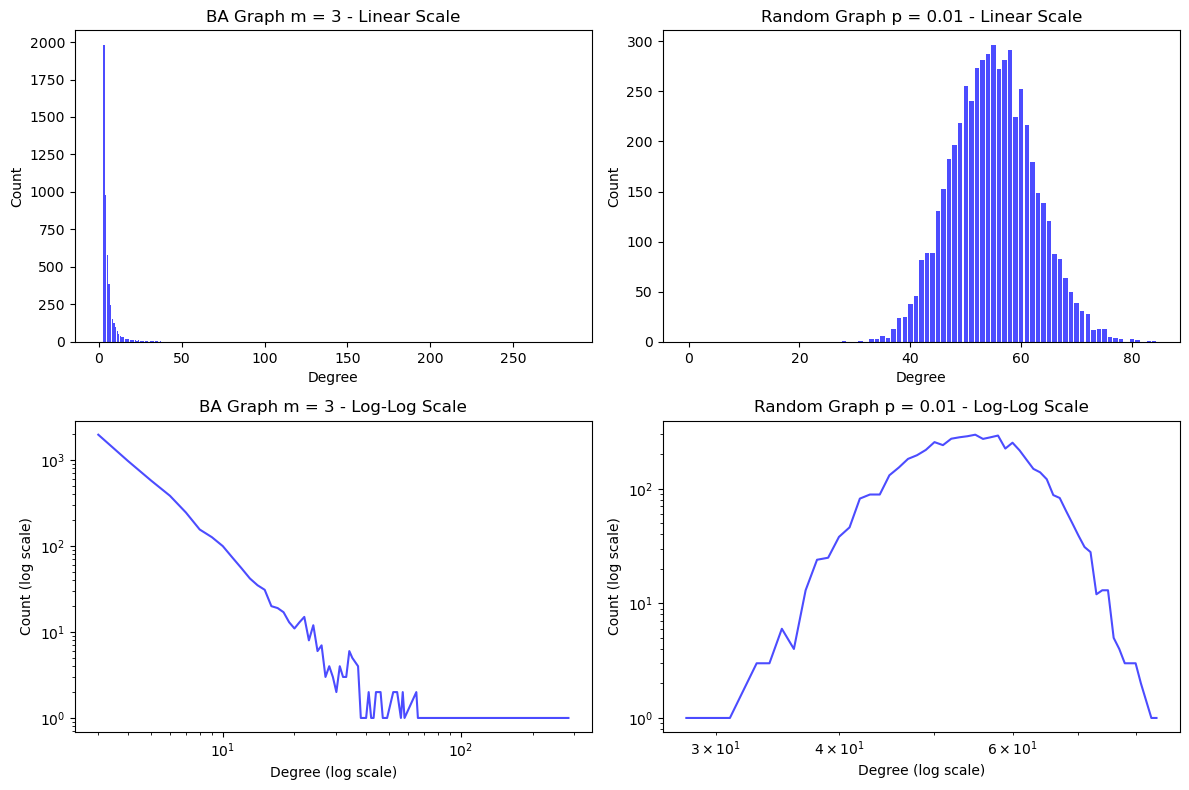

In [10]:
# Function to compute and plot degree distributions
def plot_degree_distribution(graph, title, subplot_index):
    degrees = [d for _, d in graph.degree()]
    degree_counts = np.bincount(degrees)  # Count occurrences of each degree
    degrees_range = np.arange(len(degree_counts))
    
    # Linear scale plot
    plt.subplot(2, 2, subplot_index)
    plt.bar(degrees_range, degree_counts, width=0.8, color='b', alpha=0.7)
    plt.title(f"{title} - Linear Scale")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    
    # Log-log scale plot
    plt.subplot(2, 2, subplot_index + 2)
    non_zero_indices = degrees_range[degree_counts > 0]
    non_zero_counts = degree_counts[degree_counts > 0]
    plt.loglog(non_zero_indices, non_zero_counts, 'b-', alpha=0.7)
    plt.title(f"{title} - Log-Log Scale")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("Count (log scale)")

# Plot the degree distributions for both graphs
plt.figure(figsize=(12, 8))
plot_degree_distribution(BAGraph2, "BA Graph m = 3", 1)
plot_degree_distribution(RandomGraph, "Random Graph p = 0.01", 2)
plt.tight_layout()
plt.show()

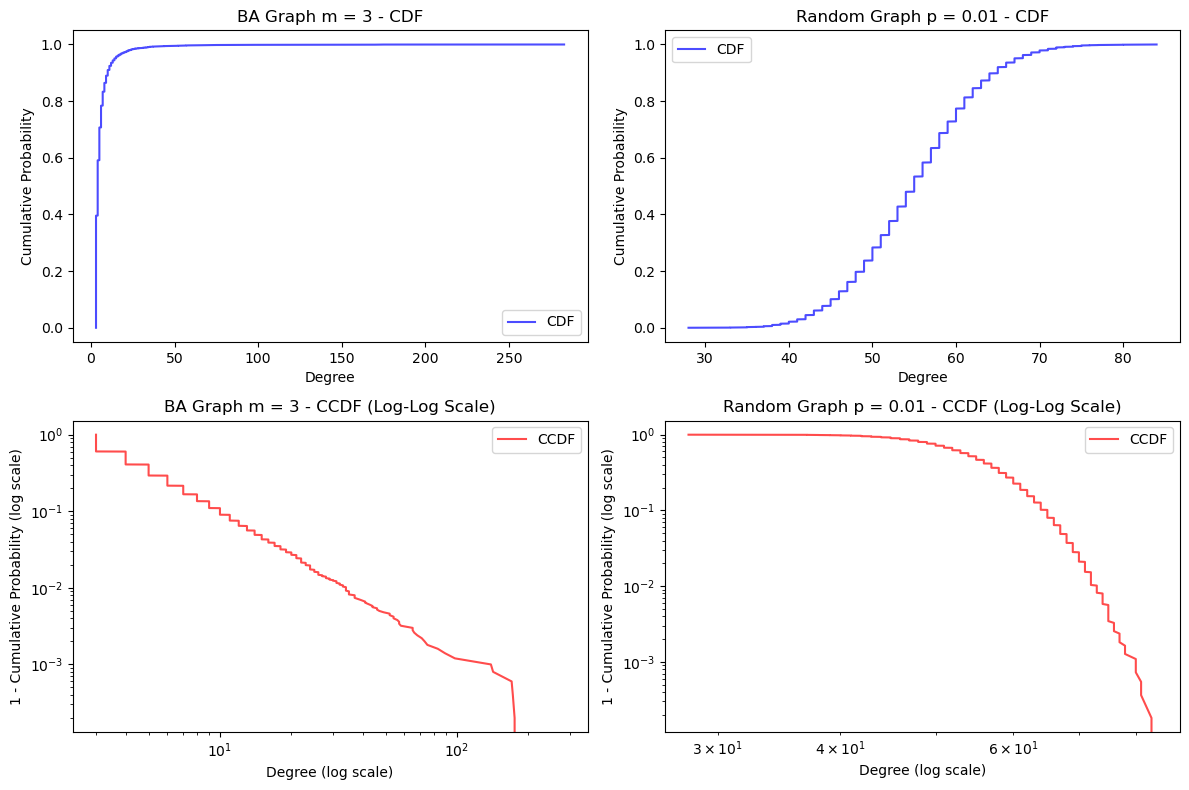

In [11]:
# Function to compute and plot CDF and CCDF
def plot_cdf_and_ccdf(graph, title, subplot_index):
    # Compute degrees and sort them
    degrees = np.array([d for _, d in graph.degree()])
    sorted_degrees = np.sort(degrees)
    
    # Calculate CDF
    cdf = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
    
    # Calculate CCDF
    ccdf = 1 - cdf

    # Plot CDF
    plt.subplot(2, 2, subplot_index)
    plt.plot(sorted_degrees, cdf, 'b-', alpha=0.7, label='CDF')
    plt.title(f"{title} - CDF")
    plt.xlabel("Degree")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    
    # Plot CCDF in log-log scale
    plt.subplot(2, 2, subplot_index + 2)
    plt.loglog(sorted_degrees, ccdf, 'r-', alpha=0.7, label='CCDF')
    plt.title(f"{title} - CCDF (Log-Log Scale)")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("1 - Cumulative Probability (log scale)")
    plt.legend()

# Plot the CDF and CCDF for both graphs
plt.figure(figsize=(12, 8))
plot_cdf_and_ccdf(BAGraph2, "BA Graph m = 3", 1)
plot_cdf_and_ccdf(RandomGraph, "Random Graph p = 0.01", 2)
plt.tight_layout()
plt.show()

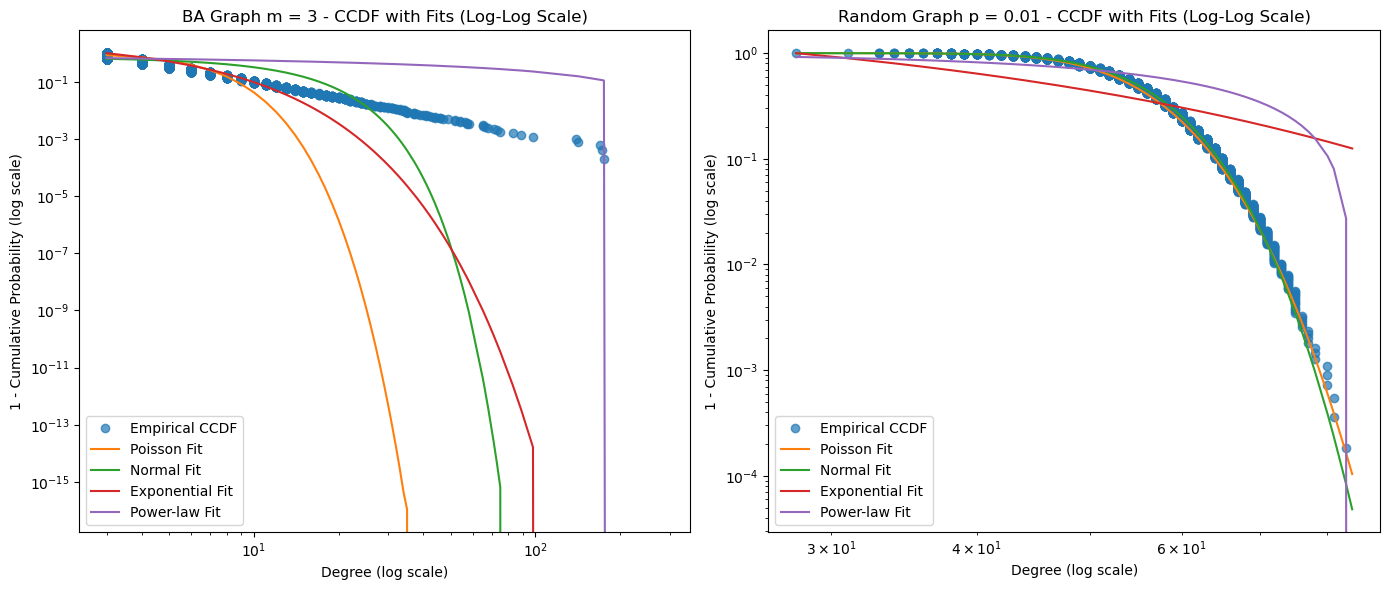

In [12]:
# Function to fit and overlay distributions on CCDF
def fit_and_plot_ccdf(graph, title, subplot_index):
    # Compute degrees and sort them
    degrees = np.array([d for _, d in graph.degree()])
    sorted_degrees = np.sort(degrees)
    
    # Calculate CCDF
    ccdf = 1 - (np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees))
    
    # Fit distributions
    # Poisson
    lambda_poisson = np.mean(degrees)
    poisson_ccdf = 1 - poisson.cdf(sorted_degrees, mu=lambda_poisson)
    
    # Normal
    mu_normal, sigma_normal = norm.fit(degrees)
    normal_ccdf = 1 - norm.cdf(sorted_degrees, loc=mu_normal, scale=sigma_normal)
    
    # Exponential
    loc_expon, scale_expon = expon.fit(degrees)
    expon_ccdf = 1 - expon.cdf(sorted_degrees, loc=loc_expon, scale=scale_expon)
    
    # Power-law
    a_power, loc_power, scale_power = powerlaw.fit(degrees, floc=0)
    power_ccdf = 1 - powerlaw.cdf(sorted_degrees, a=a_power, loc=loc_power, scale=scale_power)
    
    # Plot CCDF
    plt.subplot(1, 2, subplot_index)
    plt.loglog(sorted_degrees, ccdf, 'o', alpha=0.7, label='Empirical CCDF')
    plt.loglog(sorted_degrees, poisson_ccdf, '-', label='Poisson Fit')
    plt.loglog(sorted_degrees, normal_ccdf, '-', label='Normal Fit')
    plt.loglog(sorted_degrees, expon_ccdf, '-', label='Exponential Fit')
    plt.loglog(sorted_degrees, power_ccdf, '-', label='Power-law Fit')
    
    plt.title(f"{title} - CCDF with Fits (Log-Log Scale)")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("1 - Cumulative Probability (log scale)")
    plt.legend()

# Plot CCDF with fits for both graphs
plt.figure(figsize=(14, 6))
fit_and_plot_ccdf(BAGraph2, "BA Graph m = 3", 1)
fit_and_plot_ccdf(RandomGraph, "Random Graph p = 0.01", 2)
plt.tight_layout()
plt.show()